In [1]:
import sys, os
import numpy as np
import h5py
import math
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Cropping2D, Concatenate, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerCVAE import *

2023-12-06 11:33:47.071909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 11:33:47.786382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
LATENT_DIM = 128
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-2

In [3]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 10000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-12-06 11:33:49.239951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:33:49.316107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 11:33:49.316361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5', **args_gen)

In [5]:
# Prior
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
conv3 = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
flatten1 = Flatten()(conv1)
flatten2 = Flatten()(conv2)
flatten3 = Flatten()(conv3)
x = tf.keras.layers.Concatenate()([flatten1, flatten2, flatten3, redshifts])
x = Dense(256, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)
x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)

encoder = Model([images, redshifts], z)

In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [7]:
zc = Input(shape = (LATENT_DIM + 1,))
x = Dense(256, activation = "relu")(zc)
x = Dense(256, activation = "relu")(x)
x = Dense(128 * 32 * 32 + 64 * 32 * 32 + 32 * 64 * 64, activation = "relu")(x)
dense1, dense2, dense3 = tf.split(x, [128 * 32 * 32, 64 * 32 * 32, 32 * 64 * 64], axis = 1)
reshape1 = Reshape((128, 32, 32))(dense1)
reshape2 = Reshape((64, 32, 32))(dense2)
reshape3 = Reshape((32, 64, 64))(dense3)
deconv1 = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape1)
deconv2 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape2 + deconv1)
deconv3 = Conv2DTranspose(5, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape3 + deconv2)
cropping = Cropping2D(cropping = ((0, 1), (0, 1)), data_format = 'channels_first')(deconv3)

outputs = Reshape(IMAGE_SHAPE)(cropping)

decoder = Model(zc, outputs)

In [8]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs = [images, redshifts], outputs = decoder_output)

In [9]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 32, 32)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 128, 32, 32)  32896       ['conv2d_1[0][0]']           

In [10]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [11]:
run = neptune.init_run(
    name = "CVAE",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_127_25'

weights_path = os.path.join('/data3/Billy/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

/tmp/ipykernel_672741/726196271.py:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/astro-data-lab/VAE/e/VAE-256


In [ ]:
history = model.fit(train_gen, epochs = 25, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

In [ ]:
model.save_weights(weights_path)

In [12]:
model.load_weights(weights_path)

z = 0.0843899995


2023-12-06 11:34:08.231923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-12-06 11:34:08.360742: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-06 11:34:08.533342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


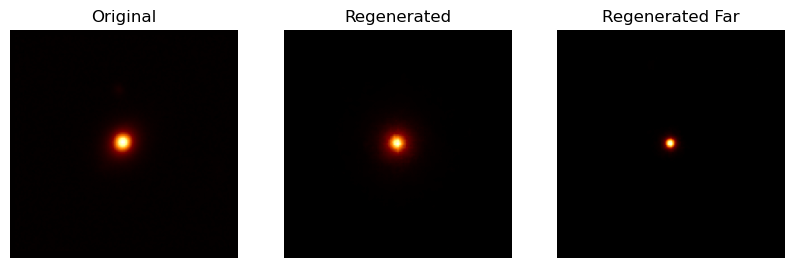

In [13]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

In [14]:
def stdev(data):
    """Calculate standard deviation, handling cases with insufficient data."""
    n = len(data)
    if n < 2:
        return 0
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data) / (n - 1)
    return math.sqrt(variance)

In [15]:
count_lo = 0
total_lo = [0, 0, 0, 0, 0]
values_for_std_dev = [[], [], [], [], []]  # List of lists to store values for each band

for i in range(len(test_gen)):
    for j in range(len(test_gen[0][0][1])):
        if test_gen[i][0][1][j] <= 0.1:
            count_lo += 1
            print(count_lo)

            for band in range(5):
                value = test_gen[i][0][0][j][band][63, 63]
                total_lo[band] += value
                values_for_std_dev[band].append(value)

            # Break if we have 10 values
            if count_lo == 10:
                break
    if count_lo == 10:
        break

# Calculating the mean and standard deviation for each band
means_lo = [sum(values)/len(values) if values else 0 for values in values_for_std_dev]
std_devs_lo = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev]

1
2
3
4
5
6
7
8
9
10


In [16]:
count_hi = 0
values_for_std_dev = [[], [], [], [], []]  # List of lists to store values for each band

for i in range(len(test_gen)):
    for j in range(len(test_gen[0][0][1])):
        if test_gen[i][0][1][j] >= 3:
            count_hi += 1
            print(count_hi)

            for band in range(5):
                value = test_gen[i][0][0][j][band][63, 63]
                values_for_std_dev[band].append(value)

            # Break if we have 10 values
            if count_hi == 10:
                break
    if count_hi == 10:
        break

# Calculating the mean and standard deviation for each band
means_hi = [sum(values)/len(values) if values else 0 for values in values_for_std_dev]
std_devs_hi = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev]

1
2
3
4
5
6
7
8
9
10


In [17]:
values_for_std_dev_lo = [[], [], [], [], []]
values_for_std_dev_hi = [[], [], [], [], []]

for i in range(0, 10):
    
    str = prior.sample(1)[0]
    strlo = np.concatenate((str, np.array([0.1])))
    strlo = strlo.reshape(1, LATENT_DIM + 1)
    strhi = np.concatenate((str, np.array([3])))
    strhi = strhi.reshape(1, LATENT_DIM + 1)
    
    for band in range(0, 5): 
        
        value_lo = decoder([strlo])[0][band][63, 63]
        value_hi = decoder([strhi])[0][band][63, 63]
        
        values_for_std_dev_lo[band].append(value_lo)
        values_for_std_dev_hi[band].append(value_hi)
        
means_lo_gen = [sum(values)/len(values) if values else 0 for values in values_for_std_dev_lo]
std_devs_lo_gen = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev_lo]
means_hi_gen = [sum(values)/len(values) if values else 0 for values in values_for_std_dev_hi]
std_devs_hi_gen = [stdev(values) if len(values) > 1 else 0 for values in values_for_std_dev_hi]

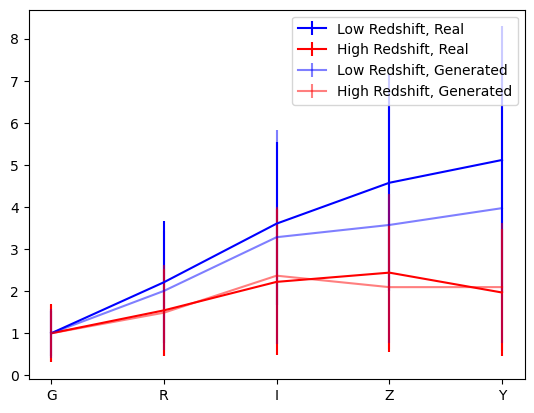

In [18]:
x = np.array([0, 1, 2, 3, 4])
bands = ['G', 'R', 'I', 'Z', 'Y']
plt.xticks(x, bands)

means_lo_normalized = [m / means_lo[0] for m in means_lo]
std_devs_lo_normalized = [std / means_lo[0] for std in std_devs_lo]
means_hi_normalized = [m / means_hi[0] for m in means_hi]
std_devs_hi_normalized = [std / means_hi[0] for std in std_devs_hi]
means_lo_gen_normalized = [m / means_lo_gen[0] for m in means_lo_gen]
std_devs_lo_gen_normalized = [std / means_lo_gen[0] for std in std_devs_lo_gen]
means_hi_gen_normalized = [m / means_hi_gen[0] for m in means_hi_gen]
std_devs_hi_gen_normalized = [std / means_hi_gen[0] for std in std_devs_hi_gen]

plt.errorbar(x, means_lo_normalized, yerr = std_devs_lo_normalized, c = 'blue', label = 'Low Redshift, Real')
plt.errorbar(x, means_hi_normalized, yerr = std_devs_hi_normalized, c = 'red', label = 'High Redshift, Real')
plt.errorbar(x, means_lo_gen_normalized, yerr = std_devs_lo_gen_normalized, c = 'blue', alpha = 0.5, label = 'Low Redshift, Generated')
plt.errorbar(x, means_hi_gen_normalized, yerr = std_devs_hi_gen_normalized, c = 'red', alpha = 0.5, label = 'High Redshift, Generated')
plt.legend()
plt.show()

In [ ]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([3.25])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

In [ ]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_testing.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(40913)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_training.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(204572)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
hf = h5py.File('/data/HSC_generated/HSC_generated_v1/step1/127x127/5x127x127_validation.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
output_image = decoder([str])[0]
image_g = output_image[0]
image_r = output_image[1]
image_i = output_image[2]
image_z = output_image[3]
image_y = output_image[4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(40913)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    output_image = decoder([str])[0]
    image_g = output_image[0]
    image_r = output_image[1]
    image_i = output_image[2]
    image_z = output_image[3]
    image_y = output_image[4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
# END